In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')

In [2]:
# uncomment to disable GPU
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Reference Model

In [3]:
# Loading trajectory
results=pd.read_csv('Resultscounty.txt',header=None,sep='\t')
results.columns=['ID','time','county','S','E','A','I','R','P','D']
# results=pd.merge(results,parameters,on='ID')
results.sort_values(['ID','time'],ascending=True,inplace=True)
dictionary=pd.read_csv('countydictionary.csv')
dictionary.columns=['COUNTY CODE','COUNTY NAME','county']
results=pd.merge(results,dictionary,on='county')
# results=resultspatch[['time','COUNTY NAME','S','E','A','I','R','P','D','beta','tauexposed','taupresymp','tauI','casefatalityrate','COUNTY CODE']]  
results=results[['ID','time','COUNTY NAME','S','E','A','I','R','P','D']]
results.loc[:,"S":"D"] = results.loc[:,"S":"D"].div(results.loc[:,"S":"D"].sum(axis =1), axis=0)
population =pd.read_csv('popCounty.txt',index_col=False,names=['ID','Population'],header=None,sep=' ')['Population'].tolist()
area =pd.read_csv('areaCounty.txt',index_col=False,names=['ID','Area'],header=None,sep=' ')['Area'].tolist()
# Getting number of patches
patches = np.unique(results['COUNTY NAME'].values)
M = len(patches)
# Getting the time length
time = np.unique(results['time'].values)
T = len(time)
# Getting number of trajectories
IDs = np.unique(results['ID'].values)
N = len(IDs)
np.set_printoptions(threshold=np.inf)
# Number of compartments
C = 7
ref_traj = np.empty((N, T, M, C))
for n in IDs:
    for m, patch_name in enumerate(patches):
        ID = results.loc[results['ID'].isin([str(n)])]
        county = ID.loc[ID['COUNTY NAME'] == patch_name]
        traj_county = county[['S','E','A','I','R','P','D']].to_numpy()
        ref_traj[n,:,m,:] = traj_county
print (np.shape(ref_traj))

(10, 201, 62, 7)


Plotting 62 patches in a 7 x 9 grid


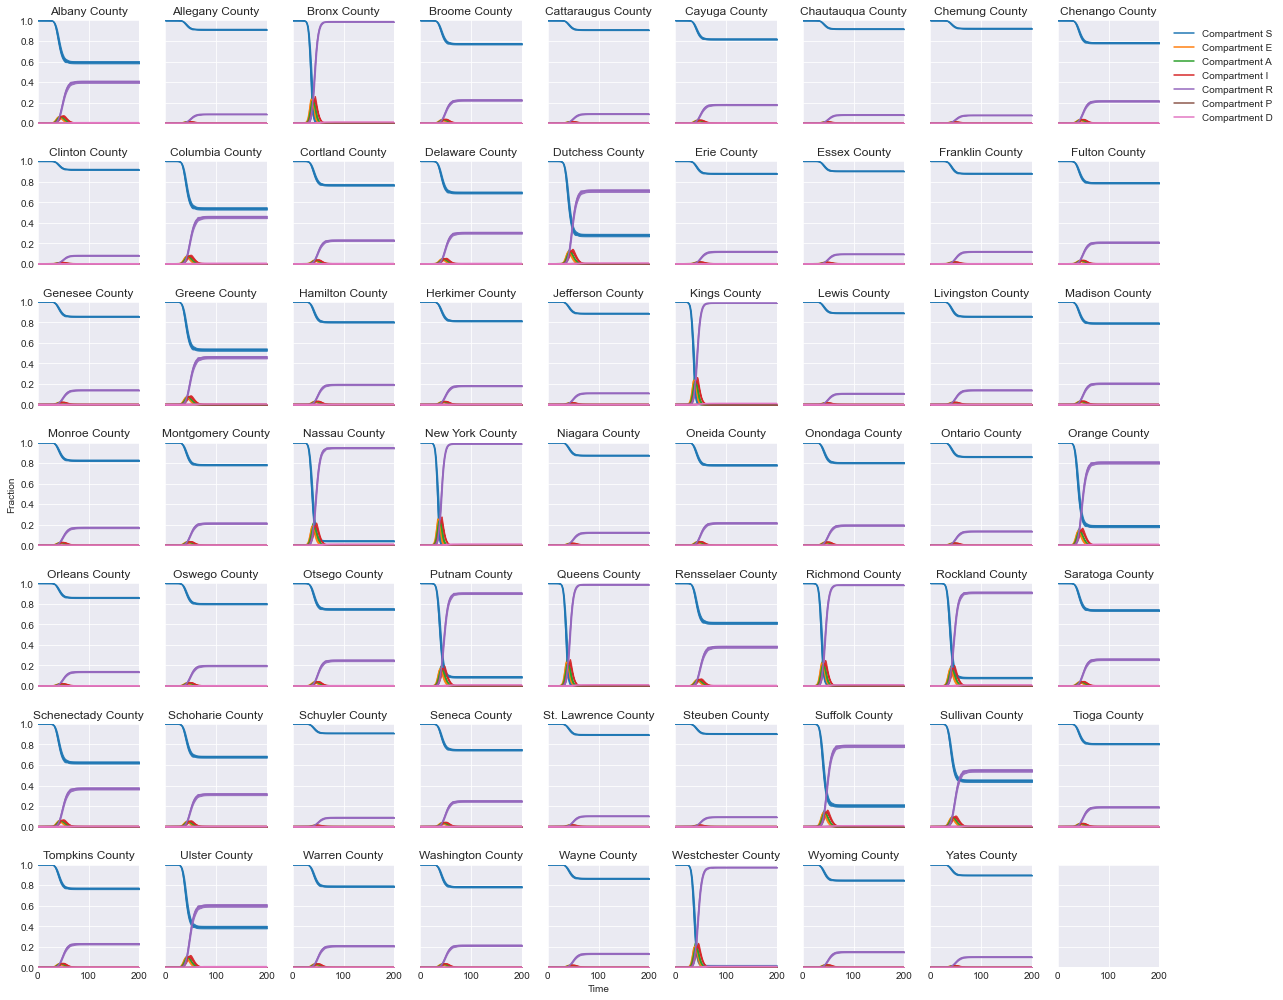

In [4]:
patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.9, names=['S','E','A','I','R','P','D'])
plt.savefig('patch_quantile.png',dpi=400)
plt.show()

In [5]:
# Run this for creating frames for animations
import plotly.graph_objs as go
import plotly.figure_factory as ff 
process_traj = False
if process_traj == True:
    for t in range(T):
        infected_portion = [round(ref_traj[0,t,i,3],2) for i in range(M)]
        zipcodes = dictionary['COUNTY CODE']
        fig = ff.create_choropleth(fips=zipcodes, 
                                   scope=['New York'],
                                   values=infected_portion,
                                   title='NY COVID-19 Infected Population Fraction by County',
                                   county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
                                   state_outline={'width': .5}
                                   )


        fig.update_layout(legend=dict(
            title='Infected Fraction',
            yanchor="top",
            y=0.95,
            xanchor="left",
            x=0.9,

        ))
        fig.add_annotation(dict(font=dict(color='black',size=30),
                                                x=0.4,
                                                y=0.12,
                                                showarrow=False,
                                                text="Day {}".format(t),
                                                textangle=0,
                                                xanchor='left',
                                                xref="paper",
                                                yref="paper"
                                                ))

        fig.layout.template = {'layout': {'font': {'family': 'Britannic Bold', 'size': 20}}}
        fig.write_image("NY_map//traj_" + str(t) +
                            ".png",width = 2048, height =1060)

ModuleNotFoundError: No module named 'plotly'

In [ ]:
# Run this for saving plots
if process_traj == True:
    for i in range(M):
        traj_quantile(ref_traj[:,:,i,:], names=['S','E','A','I','R','P','D'], add_legend=False, add_title = patches[i], plot_means=True)
        fig = plt.gcf()
        fig.set_size_inches(4, 4)
        #plt.savefig('{}.png'.format(patches[i]),dpi=400)
        plt.close()

In [4]:
# load mobility matrix
networkCounty=pd.read_csv('networkCounty.txt',header=None,sep=' ')
networkCounty.columns=['ID','County','mobility_parameter']
mobility_matrix = networkCounty.reset_index().groupby(['County'])['mobility_parameter'].apply(np.array).to_numpy()
networkCounty = networkCounty[['ID','mobility_parameter']]
Mobility_martix = np.empty([0,M])
mobility_parameter_row = np.zeros(M)
for i,row in networkCounty.iterrows():
    mobility_parameter_row[networkCounty.loc[i, 'ID']] = networkCounty.loc[i, 'mobility_parameter']
    if i < networkCounty.shape[0]-1:
        if networkCounty.loc[i+1, 'ID'] == 0:
            Mobility_martix = np.append(Mobility_martix, [mobility_parameter_row], axis=0)
            mobility_parameter_row = np.zeros(M)
    else:
         Mobility_martix = np.append(Mobility_martix, [mobility_parameter_row], axis=0)
assert (np.shape(Mobility_martix)==(M,M))
Mobility_martix_norm = Mobility_martix / np.sum(Mobility_martix, axis=1).reshape(M,1)

## Restraining a sample SEAIRPD to reference

In [5]:
# compartment parameters
compartments = ['E','A','I','R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 5, 3)
tmat.add_transition('A', 'I', 3, 2)
tmat.add_transition('I', 'R', 14, 4)
#tmat.add_transition('I', 'P', 5, 2)
#tmat.add_transition('P', 'D', 5, 2)
#tmat.add_transition('D', 'R', 5, 2)

print(tmat.value)
hyper_pram = maxentep.ParameterHypers()
hyper_pram.beta_low = 0.0001
hyper_pram.beta_high = 0.5
hyper_pram.beta_var = 0.1
hyper_pram.start_high = 0.01
# hyper_pram.start_var = 0.1
# hyper_pram.R_var = 0.001
hyper_pram.beta_start = 0.1
hyper_pram.start_mean = 0.001
# hyper_pram.start_scale = 0.1

start_logits = np.zeros((M,))
start_logits[:]=np.log(0.01)
param_model = maxentep.MetaParameterJoint(start_logits, Mobility_martix_norm , tmat, name='unbiased_model',hypers = hyper_pram )

[[0.8        0.2        0.         0.        ]
 [0.         0.66666667 0.33333333 0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


In [6]:
import tqdm
N = 256
batches = 4
outs = []
infect = maxentep.contact_infection_func(infections_compartments,area = area)
model = maxentep.MetaModel(infect, T,populations = np.round(population))
for b in tqdm.tqdm(range(batches)):
    ps = param_model.sample(N)
    outs.append(model(*ps))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.50s/it]

(1024, 201, 62, 5)


## Make restraints from reference trajectory

52 0.06820595816484552 0.06820595816484552
3 0.0 0.0
10 0.0 0.0
17 1.7084806191201018e-06 1.7084806191201018e-06
66 0.010138492724826488 0.010138492724826488
24 5.157765341904389e-05 5.157765341904389e-05
45 0.07156285290806512 0.07156285290806512
31 0.001500923471580403 0.001500923471580403


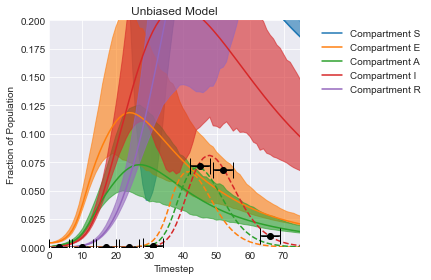

In [7]:
# Plotting restraints on reference traj
full_compartments = ['S'] + compartments
p = 1 # picking one trajectory from the parameter set
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.plot(ref_traj[p,:,0,:4], linestyle='--')
plt.title('Unbiased Model')

npoints =8
prior = maxentep.EmptyPrior()
# cutting the ref_traj in half
restraints_R, plot_fxn_R = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,3], npoints, prior, noise=0,time_average=7)
#restraints_E, plot_fxn_E = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,1], npoints, prior, noise=0,time_average=7)
#restraints_A, plot_fxn_A = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,2], npoints, prior, noise=0,time_average=7)
#restraints_I, plot_fxn_I = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,3], npoints, prior, noise=0,time_average=7)
#restraints_P, plot_fxn_P = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,5], npoints, prior, noise=0,time_average=7)
#restraints_D, plot_fxn_D = maxentep.traj_to_restraints(ref_traj[p,:75,:,:], [0,6], npoints, prior, noise=0,time_average=7)
#restraints = restraints_R + restraints_E + restraints_A + restraints_I + restraints_P + restraints_D
#plot_fxns = plot_fxn_R + plot_fxn_E + plot_fxn_A + plot_fxn_I + plot_fxn_P + plot_fxn_D
restraints = restraints_R
plot_fxns = plot_fxn_R
for i,pf in enumerate(plot_fxns):
    pf(plt.gca(), 0)
plt.tight_layout()
plt.savefig('unbiased.png',dpi=200)
plt.ylim(0,0.2)
plt.xlim(0,75)
plt.show()


In [8]:
me_model = maxentep.MaxentModel(restraints)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')

In [9]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self. i = 0
    def on_epoch_begin(self, epoch, logs=None):
        self.i += 1
        return self.i

In [10]:
me_history = me_model.fit(trajs, batch_size=64,epochs=25 * 5)#, callbacks=[CustomCallback()])

Epoch 1/125
16/16 [==============================] - 0s 2ms/step - loss: 0.0070 - weight-entropy: 4.0638
Epoch 2/125
16/16 [==============================] - 0s 2ms/step - loss: 0.0016 - weight-entropy: 3.6846
Epoch 3/125
16/16 [==============================] - 0s 1ms/step - loss: 8.4322e-04 - weight-entropy: 3.4346
Epoch 4/125
16/16 [==============================] - 0s 2ms/step - loss: 7.6668e-04 - weight-entropy: 3.3375
Epoch 5/125
16/16 [==============================] - 0s 2ms/step - loss: 6.6358e-04 - weight-entropy: 3.2744
Epoch 6/125
16/16 [==============================] - 0s 2ms/step - loss: 6.5250e-04 - weight-entropy: 3.2440
Epoch 7/125
16/16 [==============================] - 0s 2ms/step - loss: 6.5447e-04 - weight-entropy: 3.2302
Epoch 8/125
16/16 [==============================] - 0s 2ms/step - loss: 6.3094e-04 - weight-entropy: 3.2165
Epoch 9/125
16/16 [==============================] - 0s 2ms/step - loss: 6.2076e-04 - weight-entropy: 3.2127
Epoch 10/125
16/16 [=======

16/16 [==============================] - 0s 2ms/step - loss: 3.9113e-04 - weight-entropy: 3.1158
Epoch 76/125
16/16 [==============================] - 0s 2ms/step - loss: 4.0171e-04 - weight-entropy: 3.0800
Epoch 77/125
16/16 [==============================] - 0s 2ms/step - loss: 4.1771e-04 - weight-entropy: 3.0729
Epoch 78/125
16/16 [==============================] - 0s 2ms/step - loss: 3.9479e-04 - weight-entropy: 3.0858
Epoch 79/125
16/16 [==============================] - 0s 2ms/step - loss: 4.3210e-04 - weight-entropy: 3.0829
Epoch 80/125
16/16 [==============================] - 0s 2ms/step - loss: 3.8959e-04 - weight-entropy: 3.0402
Epoch 81/125
16/16 [==============================] - 0s 2ms/step - loss: 3.4954e-04 - weight-entropy: 3.0878
Epoch 82/125
16/16 [==============================] - ETA: 0s - loss: 3.3298e-04 - weight-entropy: 3.01 - 0s 2ms/step - loss: 3.8442e-04 - weight-entropy: 3.0920
Epoch 83/125
16/16 [==============================] - 0s 1ms/step - loss: 4.0873e

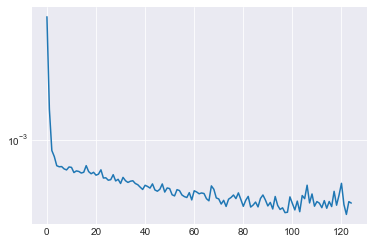

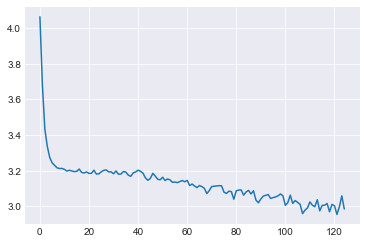

In [11]:
plt.plot(me_history.history['loss'])
plt.yscale('log')
plt.show()

plt.plot(me_history.history['weight-entropy'])
plt.show()

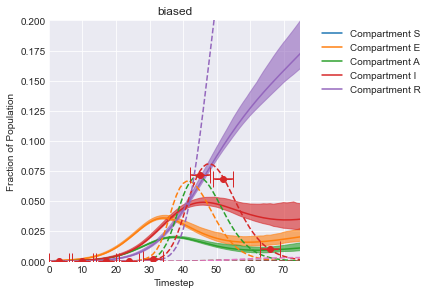

In [12]:
patch_number = 0
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments)
plt.plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(plt, me_model.lambdas[i], color='C3')
plt.tight_layout()
plt.ylim(0,0.2)
plt.xlim(0,75)
plt.title('biased')
plt.show()

## Algorithm 2

In [13]:
fit_param_model = maxentep.MetaParameterJoint(start_logits, Mobility_martix_norm , tmat, name='unbiased_model',hypers = hyper_pram )
fit_param_model.compile(tf.optimizers.Nadam(1e-2))
hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model, reweight=False)
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-1), 'mean_squared_error')

In [14]:
hme_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=25, param_epochs=50, batch_size=64, epochs=5)

Epoch 1/5
4/4 [==============================] - 0s 2ms/step - loss: 0.0108 - weight-entropy: 4.1532
Epoch 2/5
4/4 [==============================] - 0s 2ms/step - loss: 0.0071 - weight-entropy: 4.1077
Epoch 3/5
4/4 [==============================] - 0s 2ms/step - loss: 0.0044 - weight-entropy: 4.0212
Epoch 4/5
4/4 [==============================] - 0s 2ms/step - loss: 0.0028 - weight-entropy: 3.9130
Epoch 5/5
4/4 [==============================] - 0s 2ms/step - loss: 0.0020 - weight-entropy: 3.8070
Epoch 1/50
8/8 [==============================] - 0s 11ms/step - loss: 1.7406 - R-dist-dist_loss: 2.0791 - T-dist-dist_loss: -0.0143 - rho-dist-dist_loss: -0.1537 - beta-dist_loss: -0.1705
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 1.7153 - R-dist-dist_loss: 2.0571 - T-dist-dist_loss: -0.0143 - rho-dist-dist_loss: -0.1538 - beta-dist_loss: -0.1737
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 1.7005 - R-dist-dist_loss: 2.0454 - T-dist-dis

8/8 [==============================] - 0s 12ms/step - loss: 1.6466 - R-dist-dist_loss: 2.0185 - T-dist-dist_loss: -0.0145 - rho-dist-dist_loss: -0.1546 - beta-dist_loss: -0.2028
Epoch 39/50
8/8 [==============================] - 0s 11ms/step - loss: 1.6462 - R-dist-dist_loss: 2.0182 - T-dist-dist_loss: -0.0145 - rho-dist-dist_loss: -0.1546 - beta-dist_loss: -0.2029
Epoch 40/50
8/8 [==============================] - 0s 12ms/step - loss: 1.6458 - R-dist-dist_loss: 2.0180 - T-dist-dist_loss: -0.0144 - rho-dist-dist_loss: -0.1546 - beta-dist_loss: -0.2031
Epoch 41/50
8/8 [==============================] - 0s 12ms/step - loss: 1.6453 - R-dist-dist_loss: 2.0176 - T-dist-dist_loss: -0.0144 - rho-dist-dist_loss: -0.1546 - beta-dist_loss: -0.2032
Epoch 42/50
8/8 [==============================] - 0s 11ms/step - loss: 1.6454 - R-dist-dist_loss: 2.0178 - T-dist-dist_loss: -0.0145 - rho-dist-dist_loss: -0.1546 - beta-dist_loss: -0.2033
Epoch 43/50
8/8 [==============================] - 0s 12ms/ste

8/8 [==============================] - 0s 12ms/step - loss: 1.6464 - R-dist-dist_loss: 2.0525 - T-dist-dist_loss: -0.0145 - rho-dist-dist_loss: -0.1558 - beta-dist_loss: -0.2357
Epoch 29/50
8/8 [==============================] - 0s 12ms/step - loss: 1.6464 - R-dist-dist_loss: 2.0526 - T-dist-dist_loss: -0.0145 - rho-dist-dist_loss: -0.1558 - beta-dist_loss: -0.2358
Epoch 30/50
8/8 [==============================] - 0s 11ms/step - loss: 1.6460 - R-dist-dist_loss: 2.0523 - T-dist-dist_loss: -0.0145 - rho-dist-dist_loss: -0.1558 - beta-dist_loss: -0.2359
Epoch 31/50
8/8 [==============================] - 0s 11ms/step - loss: 1.6457 - R-dist-dist_loss: 2.0521 - T-dist-dist_loss: -0.0145 - rho-dist-dist_loss: -0.1559 - beta-dist_loss: -0.2360
Epoch 32/50
8/8 [==============================] - 0s 12ms/step - loss: 1.6455 - R-dist-dist_loss: 2.0520 - T-dist-dist_loss: -0.0145 - rho-dist-dist_loss: -0.1559 - beta-dist_loss: -0.2361
Epoch 33/50
8/8 [==============================] - 0s 11ms/ste

8/8 [==============================] - 0s 13ms/step - loss: 1.7339 - R-dist-dist_loss: 2.1449 - T-dist-dist_loss: -0.0149 - rho-dist-dist_loss: -0.1561 - beta-dist_loss: -0.2400
Epoch 18/50
8/8 [==============================] - 0s 12ms/step - loss: 1.7336 - R-dist-dist_loss: 2.1447 - T-dist-dist_loss: -0.0149 - rho-dist-dist_loss: -0.1561 - beta-dist_loss: -0.2401
Epoch 19/50
8/8 [==============================] - 0s 12ms/step - loss: 1.7332 - R-dist-dist_loss: 2.1443 - T-dist-dist_loss: -0.0149 - rho-dist-dist_loss: -0.1561 - beta-dist_loss: -0.2401
Epoch 20/50
8/8 [==============================] - 0s 12ms/step - loss: 1.7325 - R-dist-dist_loss: 2.1437 - T-dist-dist_loss: -0.0149 - rho-dist-dist_loss: -0.1561 - beta-dist_loss: -0.2401
Epoch 21/50
8/8 [==============================] - 0s 11ms/step - loss: 1.7323 - R-dist-dist_loss: 2.1435 - T-dist-dist_loss: -0.0149 - rho-dist-dist_loss: -0.1561 - beta-dist_loss: -0.2402
Epoch 22/50
8/8 [==============================] - 0s 12ms/ste

8/8 [==============================] - 0s 11ms/step - loss: 1.8352 - R-dist-dist_loss: 2.2460 - T-dist-dist_loss: -0.0139 - rho-dist-dist_loss: -0.1567 - beta-dist_loss: -0.2401
Epoch 8/50
8/8 [==============================] - 0s 11ms/step - loss: 1.8338 - R-dist-dist_loss: 2.2446 - T-dist-dist_loss: -0.0139 - rho-dist-dist_loss: -0.1567 - beta-dist_loss: -0.2401
Epoch 9/50
8/8 [==============================] - 0s 11ms/step - loss: 1.8330 - R-dist-dist_loss: 2.2438 - T-dist-dist_loss: -0.0139 - rho-dist-dist_loss: -0.1568 - beta-dist_loss: -0.2402
Epoch 10/50
8/8 [==============================] - 0s 12ms/step - loss: 1.8320 - R-dist-dist_loss: 2.2429 - T-dist-dist_loss: -0.0140 - rho-dist-dist_loss: -0.1568 - beta-dist_loss: -0.2402
Epoch 11/50
8/8 [==============================] - 0s 12ms/step - loss: 1.8319 - R-dist-dist_loss: 2.2429 - T-dist-dist_loss: -0.0140 - rho-dist-dist_loss: -0.1568 - beta-dist_loss: -0.2402
Epoch 12/50
8/8 [==============================] - 0s 11ms/step 

8/8 [==============================] - 0s 13ms/step - loss: 1.8225 - R-dist-dist_loss: 2.2341 - T-dist-dist_loss: -0.0140 - rho-dist-dist_loss: -0.1571 - beta-dist_loss: -0.2406
Epoch 1/5
4/4 [==============================] - 0s 2ms/step - loss: 4.9771e-04 - weight-entropy: 3.7338
Epoch 2/5
4/4 [==============================] - 0s 2ms/step - loss: 5.0484e-04 - weight-entropy: 3.7378
Epoch 3/5
4/4 [==============================] - 0s 2ms/step - loss: 4.9257e-04 - weight-entropy: 3.7389
Epoch 4/5
4/4 [==============================] - 0s 2ms/step - loss: 5.0991e-04 - weight-entropy: 3.7425
Epoch 5/5
4/4 [==============================] - 0s 2ms/step - loss: 4.8344e-04 - weight-entropy: 3.7428
Epoch 1/50
8/8 [==============================] - 0s 12ms/step - loss: 1.9472 - R-dist-dist_loss: 2.3591 - T-dist-dist_loss: -0.0136 - rho-dist-dist_loss: -0.1569 - beta-dist_loss: -0.2413
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 1.9270 - R-dist-dist_loss: 2.3389 - T

8/8 [==============================] - 0s 12ms/step - loss: 1.8945 - R-dist-dist_loss: 2.3073 - T-dist-dist_loss: -0.0137 - rho-dist-dist_loss: -0.1576 - beta-dist_loss: -0.2416
Epoch 40/50
8/8 [==============================] - 0s 11ms/step - loss: 1.8943 - R-dist-dist_loss: 2.3071 - T-dist-dist_loss: -0.0137 - rho-dist-dist_loss: -0.1576 - beta-dist_loss: -0.2416
Epoch 41/50
8/8 [==============================] - 0s 11ms/step - loss: 1.8943 - R-dist-dist_loss: 2.3071 - T-dist-dist_loss: -0.0137 - rho-dist-dist_loss: -0.1576 - beta-dist_loss: -0.2416
Epoch 42/50
8/8 [==============================] - 0s 12ms/step - loss: 1.8942 - R-dist-dist_loss: 2.3070 - T-dist-dist_loss: -0.0137 - rho-dist-dist_loss: -0.1576 - beta-dist_loss: -0.2416
Epoch 43/50
8/8 [==============================] - 0s 12ms/step - loss: 1.8939 - R-dist-dist_loss: 2.3067 - T-dist-dist_loss: -0.0137 - rho-dist-dist_loss: -0.1576 - beta-dist_loss: -0.2416
Epoch 44/50
8/8 [==============================] - 0s 13ms/ste

8/8 [==============================] - 0s 12ms/step - loss: 2.0274 - R-dist-dist_loss: 2.4383 - T-dist-dist_loss: -0.0131 - rho-dist-dist_loss: -0.1574 - beta-dist_loss: -0.2404
Epoch 30/50
8/8 [==============================] - 0s 11ms/step - loss: 2.0272 - R-dist-dist_loss: 2.4382 - T-dist-dist_loss: -0.0132 - rho-dist-dist_loss: -0.1574 - beta-dist_loss: -0.2404
Epoch 31/50
8/8 [==============================] - 0s 12ms/step - loss: 2.0273 - R-dist-dist_loss: 2.4382 - T-dist-dist_loss: -0.0131 - rho-dist-dist_loss: -0.1574 - beta-dist_loss: -0.2404
Epoch 32/50
8/8 [==============================] - 0s 12ms/step - loss: 2.0268 - R-dist-dist_loss: 2.4378 - T-dist-dist_loss: -0.0132 - rho-dist-dist_loss: -0.1575 - beta-dist_loss: -0.2404
Epoch 33/50
8/8 [==============================] - 0s 12ms/step - loss: 2.0269 - R-dist-dist_loss: 2.4378 - T-dist-dist_loss: -0.0131 - rho-dist-dist_loss: -0.1575 - beta-dist_loss: -0.2404
Epoch 34/50
8/8 [==============================] - 0s 11ms/ste

8/8 [==============================] - 0s 11ms/step - loss: 2.1346 - R-dist-dist_loss: 2.5402 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1568 - beta-dist_loss: -0.2363
Epoch 20/50
8/8 [==============================] - 0s 11ms/step - loss: 2.1339 - R-dist-dist_loss: 2.5396 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1568 - beta-dist_loss: -0.2363
Epoch 21/50
8/8 [==============================] - 0s 12ms/step - loss: 2.1337 - R-dist-dist_loss: 2.5394 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1568 - beta-dist_loss: -0.2363
Epoch 22/50
8/8 [==============================] - 0s 12ms/step - loss: 2.1335 - R-dist-dist_loss: 2.5392 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1569 - beta-dist_loss: -0.2363
Epoch 23/50
8/8 [==============================] - 0s 12ms/step - loss: 2.1333 - R-dist-dist_loss: 2.5390 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1569 - beta-dist_loss: -0.2363
Epoch 24/50
8/8 [==============================] - 0s 12ms/ste

8/8 [==============================] - 0s 11ms/step - loss: 2.2173 - R-dist-dist_loss: 2.6189 - T-dist-dist_loss: -0.0124 - rho-dist-dist_loss: -0.1569 - beta-dist_loss: -0.2323
Epoch 10/50
8/8 [==============================] - 0s 12ms/step - loss: 2.2166 - R-dist-dist_loss: 2.6183 - T-dist-dist_loss: -0.0124 - rho-dist-dist_loss: -0.1569 - beta-dist_loss: -0.2323
Epoch 11/50
8/8 [==============================] - 0s 11ms/step - loss: 2.2158 - R-dist-dist_loss: 2.6175 - T-dist-dist_loss: -0.0124 - rho-dist-dist_loss: -0.1569 - beta-dist_loss: -0.2323
Epoch 12/50
8/8 [==============================] - 0s 11ms/step - loss: 2.2150 - R-dist-dist_loss: 2.6167 - T-dist-dist_loss: -0.0124 - rho-dist-dist_loss: -0.1570 - beta-dist_loss: -0.2323
Epoch 13/50
8/8 [==============================] - 0s 12ms/step - loss: 2.2142 - R-dist-dist_loss: 2.6159 - T-dist-dist_loss: -0.0124 - rho-dist-dist_loss: -0.1570 - beta-dist_loss: -0.2323
Epoch 14/50
8/8 [==============================] - 0s 12ms/ste

4/4 [==============================] - 0s 2ms/step - loss: 4.7560e-04 - weight-entropy: 3.8573
Epoch 4/5
4/4 [==============================] - 0s 2ms/step - loss: 4.8584e-04 - weight-entropy: 3.8608
Epoch 5/5
4/4 [==============================] - 0s 1ms/step - loss: 4.9478e-04 - weight-entropy: 3.8635
Epoch 1/50
8/8 [==============================] - 0s 12ms/step - loss: 2.3201 - R-dist-dist_loss: 2.7254 - T-dist-dist_loss: -0.0125 - rho-dist-dist_loss: -0.1570 - beta-dist_loss: -0.2357
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 2.3022 - R-dist-dist_loss: 2.7075 - T-dist-dist_loss: -0.0125 - rho-dist-dist_loss: -0.1570 - beta-dist_loss: -0.2357
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 2.2920 - R-dist-dist_loss: 2.6973 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1571 - beta-dist_loss: -0.2357
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 2.2878 - R-dist-dist_loss: 2.6932 - T-dist-dist_loss: -0.

8/8 [==============================] - 0s 12ms/step - loss: 2.2711 - R-dist-dist_loss: 2.6767 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1573 - beta-dist_loss: -0.2357
Epoch 43/50
8/8 [==============================] - 0s 12ms/step - loss: 2.2710 - R-dist-dist_loss: 2.6766 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1573 - beta-dist_loss: -0.2357
Epoch 44/50
8/8 [==============================] - 0s 11ms/step - loss: 2.2707 - R-dist-dist_loss: 2.6763 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1573 - beta-dist_loss: -0.2357
Epoch 45/50
8/8 [==============================] - 0s 12ms/step - loss: 2.2706 - R-dist-dist_loss: 2.6762 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1573 - beta-dist_loss: -0.2357
Epoch 46/50
8/8 [==============================] - 0s 11ms/step - loss: 2.2708 - R-dist-dist_loss: 2.6764 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1573 - beta-dist_loss: -0.2357
Epoch 47/50
8/8 [==============================] - 0s 11ms/ste

8/8 [==============================] - 0s 12ms/step - loss: 2.3577 - R-dist-dist_loss: 2.7612 - T-dist-dist_loss: -0.0115 - rho-dist-dist_loss: -0.1576 - beta-dist_loss: -0.2344
Epoch 33/50
8/8 [==============================] - 0s 11ms/step - loss: 2.3577 - R-dist-dist_loss: 2.7611 - T-dist-dist_loss: -0.0115 - rho-dist-dist_loss: -0.1576 - beta-dist_loss: -0.2344
Epoch 34/50
8/8 [==============================] - 0s 11ms/step - loss: 2.3577 - R-dist-dist_loss: 2.7611 - T-dist-dist_loss: -0.0115 - rho-dist-dist_loss: -0.1576 - beta-dist_loss: -0.2344
Epoch 35/50
8/8 [==============================] - 0s 11ms/step - loss: 2.3573 - R-dist-dist_loss: 2.7607 - T-dist-dist_loss: -0.0115 - rho-dist-dist_loss: -0.1576 - beta-dist_loss: -0.2344
Epoch 36/50
8/8 [==============================] - 0s 11ms/step - loss: 2.3573 - R-dist-dist_loss: 2.7608 - T-dist-dist_loss: -0.0115 - rho-dist-dist_loss: -0.1576 - beta-dist_loss: -0.2344
Epoch 37/50
8/8 [==============================] - 0s 12ms/ste

8/8 [==============================] - 0s 11ms/step - loss: 2.4415 - R-dist-dist_loss: 2.8437 - T-dist-dist_loss: -0.0117 - rho-dist-dist_loss: -0.1582 - beta-dist_loss: -0.2324
Epoch 23/50
8/8 [==============================] - 0s 12ms/step - loss: 2.4416 - R-dist-dist_loss: 2.8438 - T-dist-dist_loss: -0.0117 - rho-dist-dist_loss: -0.1582 - beta-dist_loss: -0.2324
Epoch 24/50
8/8 [==============================] - 0s 12ms/step - loss: 2.4411 - R-dist-dist_loss: 2.8433 - T-dist-dist_loss: -0.0117 - rho-dist-dist_loss: -0.1582 - beta-dist_loss: -0.2324
Epoch 25/50
8/8 [==============================] - 0s 12ms/step - loss: 2.4409 - R-dist-dist_loss: 2.8431 - T-dist-dist_loss: -0.0117 - rho-dist-dist_loss: -0.1582 - beta-dist_loss: -0.2324
Epoch 26/50
8/8 [==============================] - 0s 12ms/step - loss: 2.4403 - R-dist-dist_loss: 2.8426 - T-dist-dist_loss: -0.0117 - rho-dist-dist_loss: -0.1582 - beta-dist_loss: -0.2324
Epoch 27/50
8/8 [==============================] - 0s 11ms/ste

8/8 [==============================] - 0s 12ms/step - loss: 2.5266 - R-dist-dist_loss: 2.9294 - T-dist-dist_loss: -0.0114 - rho-dist-dist_loss: -0.1584 - beta-dist_loss: -0.2330
Epoch 12/50
8/8 [==============================] - 0s 12ms/step - loss: 2.5259 - R-dist-dist_loss: 2.9287 - T-dist-dist_loss: -0.0114 - rho-dist-dist_loss: -0.1584 - beta-dist_loss: -0.2330
Epoch 13/50
8/8 [==============================] - 0s 11ms/step - loss: 2.5253 - R-dist-dist_loss: 2.9281 - T-dist-dist_loss: -0.0114 - rho-dist-dist_loss: -0.1584 - beta-dist_loss: -0.2330
Epoch 14/50
8/8 [==============================] - 0s 11ms/step - loss: 2.5249 - R-dist-dist_loss: 2.9277 - T-dist-dist_loss: -0.0114 - rho-dist-dist_loss: -0.1584 - beta-dist_loss: -0.2330
Epoch 15/50
8/8 [==============================] - 0s 11ms/step - loss: 2.5244 - R-dist-dist_loss: 2.9272 - T-dist-dist_loss: -0.0114 - rho-dist-dist_loss: -0.1584 - beta-dist_loss: -0.2330
Epoch 16/50
8/8 [==============================] - 0s 12ms/ste

8/8 [==============================] - 0s 10ms/step - loss: 2.6641 - R-dist-dist_loss: 3.0536 - T-dist-dist_loss: -0.0109 - rho-dist-dist_loss: -0.1584 - beta-dist_loss: -0.2202
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 2.6469 - R-dist-dist_loss: 3.0365 - T-dist-dist_loss: -0.0110 - rho-dist-dist_loss: -0.1584 - beta-dist_loss: -0.2202
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 2.6382 - R-dist-dist_loss: 3.0278 - T-dist-dist_loss: -0.0110 - rho-dist-dist_loss: -0.1585 - beta-dist_loss: -0.2202
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 2.6340 - R-dist-dist_loss: 3.0237 - T-dist-dist_loss: -0.0110 - rho-dist-dist_loss: -0.1585 - beta-dist_loss: -0.2202
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 2.6321 - R-dist-dist_loss: 3.0219 - T-dist-dist_loss: -0.0110 - rho-dist-dist_loss: -0.1585 - beta-dist_loss: -0.2202
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - l

8/8 [==============================] - 0s 11ms/step - loss: 2.6184 - R-dist-dist_loss: 3.0084 - T-dist-dist_loss: -0.0111 - rho-dist-dist_loss: -0.1587 - beta-dist_loss: -0.2202
Epoch 45/50
8/8 [==============================] - 0s 11ms/step - loss: 2.6182 - R-dist-dist_loss: 3.0083 - T-dist-dist_loss: -0.0111 - rho-dist-dist_loss: -0.1587 - beta-dist_loss: -0.2202
Epoch 46/50
8/8 [==============================] - 0s 11ms/step - loss: 2.6183 - R-dist-dist_loss: 3.0084 - T-dist-dist_loss: -0.0111 - rho-dist-dist_loss: -0.1587 - beta-dist_loss: -0.2202
Epoch 47/50
8/8 [==============================] - 0s 12ms/step - loss: 2.6182 - R-dist-dist_loss: 3.0082 - T-dist-dist_loss: -0.0111 - rho-dist-dist_loss: -0.1587 - beta-dist_loss: -0.2202
Epoch 48/50
8/8 [==============================] - 0s 11ms/step - loss: 2.6180 - R-dist-dist_loss: 3.0081 - T-dist-dist_loss: -0.0111 - rho-dist-dist_loss: -0.1587 - beta-dist_loss: -0.2202
Epoch 49/50
8/8 [==============================] - 0s 12ms/ste

8/8 [==============================] - 0s 11ms/step - loss: 2.6861 - R-dist-dist_loss: 3.0779 - T-dist-dist_loss: -0.0118 - rho-dist-dist_loss: -0.1586 - beta-dist_loss: -0.2215
Epoch 35/50
8/8 [==============================] - 0s 11ms/step - loss: 2.6862 - R-dist-dist_loss: 3.0780 - T-dist-dist_loss: -0.0118 - rho-dist-dist_loss: -0.1586 - beta-dist_loss: -0.2215
Epoch 36/50
8/8 [==============================] - 0s 11ms/step - loss: 2.6860 - R-dist-dist_loss: 3.0778 - T-dist-dist_loss: -0.0118 - rho-dist-dist_loss: -0.1586 - beta-dist_loss: -0.2215
Epoch 37/50
8/8 [==============================] - 0s 12ms/step - loss: 2.6858 - R-dist-dist_loss: 3.0777 - T-dist-dist_loss: -0.0118 - rho-dist-dist_loss: -0.1586 - beta-dist_loss: -0.2215
Epoch 38/50
8/8 [==============================] - 0s 10ms/step - loss: 2.6858 - R-dist-dist_loss: 3.0777 - T-dist-dist_loss: -0.0118 - rho-dist-dist_loss: -0.1586 - beta-dist_loss: -0.2215
Epoch 39/50
8/8 [==============================] - 0s 12ms/ste

8/8 [==============================] - 0s 11ms/step - loss: 2.7683 - R-dist-dist_loss: 3.1574 - T-dist-dist_loss: -0.0119 - rho-dist-dist_loss: -0.1583 - beta-dist_loss: -0.2189
Epoch 25/50
8/8 [==============================] - 0s 12ms/step - loss: 2.7680 - R-dist-dist_loss: 3.1571 - T-dist-dist_loss: -0.0119 - rho-dist-dist_loss: -0.1583 - beta-dist_loss: -0.2189
Epoch 26/50
8/8 [==============================] - 0s 13ms/step - loss: 2.7680 - R-dist-dist_loss: 3.1570 - T-dist-dist_loss: -0.0119 - rho-dist-dist_loss: -0.1583 - beta-dist_loss: -0.2189
Epoch 27/50
8/8 [==============================] - 0s 13ms/step - loss: 2.7678 - R-dist-dist_loss: 3.1569 - T-dist-dist_loss: -0.0119 - rho-dist-dist_loss: -0.1583 - beta-dist_loss: -0.2189
Epoch 28/50
8/8 [==============================] - 0s 12ms/step - loss: 2.7678 - R-dist-dist_loss: 3.1569 - T-dist-dist_loss: -0.0119 - rho-dist-dist_loss: -0.1583 - beta-dist_loss: -0.2189
Epoch 29/50
8/8 [==============================] - 0s 11ms/ste

8/8 [==============================] - 0s 11ms/step - loss: 2.8362 - R-dist-dist_loss: 3.2262 - T-dist-dist_loss: -0.0122 - rho-dist-dist_loss: -0.1586 - beta-dist_loss: -0.2191
Epoch 15/50
8/8 [==============================] - 0s 12ms/step - loss: 2.8355 - R-dist-dist_loss: 3.2255 - T-dist-dist_loss: -0.0122 - rho-dist-dist_loss: -0.1586 - beta-dist_loss: -0.2191
Epoch 16/50
8/8 [==============================] - 0s 12ms/step - loss: 2.8353 - R-dist-dist_loss: 3.2252 - T-dist-dist_loss: -0.0122 - rho-dist-dist_loss: -0.1586 - beta-dist_loss: -0.2191
Epoch 17/50
8/8 [==============================] - 0s 14ms/step - loss: 2.8349 - R-dist-dist_loss: 3.2248 - T-dist-dist_loss: -0.0122 - rho-dist-dist_loss: -0.1586 - beta-dist_loss: -0.2191
Epoch 18/50
8/8 [==============================] - 0s 15ms/step - loss: 2.8344 - R-dist-dist_loss: 3.2244 - T-dist-dist_loss: -0.0122 - rho-dist-dist_loss: -0.1587 - beta-dist_loss: -0.2191
Epoch 19/50
8/8 [==============================] - 0s 12ms/ste

8/8 [==============================] - 0s 12ms/step - loss: 2.8918 - R-dist-dist_loss: 3.2788 - T-dist-dist_loss: -0.0124 - rho-dist-dist_loss: -0.1589 - beta-dist_loss: -0.2157
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 2.8902 - R-dist-dist_loss: 3.2772 - T-dist-dist_loss: -0.0124 - rho-dist-dist_loss: -0.1589 - beta-dist_loss: -0.2157
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 2.8887 - R-dist-dist_loss: 3.2757 - T-dist-dist_loss: -0.0124 - rho-dist-dist_loss: -0.1589 - beta-dist_loss: -0.2157
Epoch 7/50
8/8 [==============================] - 0s 12ms/step - loss: 2.8875 - R-dist-dist_loss: 3.2745 - T-dist-dist_loss: -0.0125 - rho-dist-dist_loss: -0.1590 - beta-dist_loss: -0.2157
Epoch 8/50
8/8 [==============================] - 0s 12ms/step - loss: 2.8866 - R-dist-dist_loss: 3.2736 - T-dist-dist_loss: -0.0124 - rho-dist-dist_loss: -0.1590 - beta-dist_loss: -0.2157
Epoch 9/50
8/8 [==============================] - 0s 11ms/step - l

8/8 [==============================] - 0s 11ms/step - loss: 2.8772 - R-dist-dist_loss: 3.2643 - T-dist-dist_loss: -0.0125 - rho-dist-dist_loss: -0.1591 - beta-dist_loss: -0.2157
Epoch 48/50
8/8 [==============================] - 0s 11ms/step - loss: 2.8772 - R-dist-dist_loss: 3.2644 - T-dist-dist_loss: -0.0124 - rho-dist-dist_loss: -0.1591 - beta-dist_loss: -0.2157
Epoch 49/50
8/8 [==============================] - 0s 11ms/step - loss: 2.8773 - R-dist-dist_loss: 3.2645 - T-dist-dist_loss: -0.0125 - rho-dist-dist_loss: -0.1591 - beta-dist_loss: -0.2157
Epoch 50/50
8/8 [==============================] - 0s 12ms/step - loss: 2.8770 - R-dist-dist_loss: 3.2641 - T-dist-dist_loss: -0.0125 - rho-dist-dist_loss: -0.1591 - beta-dist_loss: -0.2157
Epoch 1/5
4/4 [==============================] - 0s 2ms/step - loss: 4.8747e-04 - weight-entropy: 4.1048
Epoch 2/5
4/4 [==============================] - 0s 2ms/step - loss: 4.8250e-04 - weight-entropy: 4.1056
Epoch 3/5
4/4 [===========================

8/8 [==============================] - 0s 12ms/step - loss: 2.9227 - R-dist-dist_loss: 3.3194 - T-dist-dist_loss: -0.0127 - rho-dist-dist_loss: -0.1596 - beta-dist_loss: -0.2244
Epoch 38/50
8/8 [==============================] - 0s 12ms/step - loss: 2.9227 - R-dist-dist_loss: 3.3194 - T-dist-dist_loss: -0.0127 - rho-dist-dist_loss: -0.1596 - beta-dist_loss: -0.2244
Epoch 39/50
8/8 [==============================] - 0s 12ms/step - loss: 2.9230 - R-dist-dist_loss: 3.3197 - T-dist-dist_loss: -0.0127 - rho-dist-dist_loss: -0.1596 - beta-dist_loss: -0.2244
Epoch 40/50
8/8 [==============================] - 0s 12ms/step - loss: 2.9226 - R-dist-dist_loss: 3.3193 - T-dist-dist_loss: -0.0127 - rho-dist-dist_loss: -0.1596 - beta-dist_loss: -0.2244
Epoch 41/50
8/8 [==============================] - 0s 11ms/step - loss: 2.9226 - R-dist-dist_loss: 3.3193 - T-dist-dist_loss: -0.0127 - rho-dist-dist_loss: -0.1596 - beta-dist_loss: -0.2244
Epoch 42/50
8/8 [==============================] - 0s 11ms/ste

8/8 [==============================] - 0s 12ms/step - loss: 2.9967 - R-dist-dist_loss: 3.3840 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1603 - beta-dist_loss: -0.2144
Epoch 28/50
8/8 [==============================] - 0s 11ms/step - loss: 2.9963 - R-dist-dist_loss: 3.3836 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1603 - beta-dist_loss: -0.2144
Epoch 29/50
8/8 [==============================] - 0s 12ms/step - loss: 2.9961 - R-dist-dist_loss: 3.3834 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1603 - beta-dist_loss: -0.2144
Epoch 30/50
8/8 [==============================] - 0s 11ms/step - loss: 2.9961 - R-dist-dist_loss: 3.3834 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1603 - beta-dist_loss: -0.2144
Epoch 31/50
8/8 [==============================] - 0s 12ms/step - loss: 2.9961 - R-dist-dist_loss: 3.3834 - T-dist-dist_loss: -0.0126 - rho-dist-dist_loss: -0.1603 - beta-dist_loss: -0.2144
Epoch 32/50
8/8 [==============================] - 0s 12ms/ste

8/8 [==============================] - 0s 11ms/step - loss: 3.0408 - R-dist-dist_loss: 3.4368 - T-dist-dist_loss: -0.0121 - rho-dist-dist_loss: -0.1596 - beta-dist_loss: -0.2244
Epoch 18/50
8/8 [==============================] - 0s 12ms/step - loss: 3.0404 - R-dist-dist_loss: 3.4364 - T-dist-dist_loss: -0.0121 - rho-dist-dist_loss: -0.1596 - beta-dist_loss: -0.2244
Epoch 19/50
8/8 [==============================] - 0s 12ms/step - loss: 3.0403 - R-dist-dist_loss: 3.4363 - T-dist-dist_loss: -0.0121 - rho-dist-dist_loss: -0.1596 - beta-dist_loss: -0.2244
Epoch 20/50
8/8 [==============================] - 0s 12ms/step - loss: 3.0400 - R-dist-dist_loss: 3.4359 - T-dist-dist_loss: -0.0121 - rho-dist-dist_loss: -0.1596 - beta-dist_loss: -0.2244
Epoch 21/50
8/8 [==============================] - 0s 11ms/step - loss: 3.0398 - R-dist-dist_loss: 3.4358 - T-dist-dist_loss: -0.0121 - rho-dist-dist_loss: -0.1596 - beta-dist_loss: -0.2244
Epoch 22/50
8/8 [==============================] - 0s 12ms/ste

8/8 [==============================] - 0s 12ms/step - loss: 3.0916 - R-dist-dist_loss: 3.4830 - T-dist-dist_loss: -0.0120 - rho-dist-dist_loss: -0.1587 - beta-dist_loss: -0.2207
Epoch 8/50
8/8 [==============================] - 0s 12ms/step - loss: 3.0907 - R-dist-dist_loss: 3.4821 - T-dist-dist_loss: -0.0120 - rho-dist-dist_loss: -0.1588 - beta-dist_loss: -0.2207
Epoch 9/50
8/8 [==============================] - 0s 13ms/step - loss: 3.0898 - R-dist-dist_loss: 3.4813 - T-dist-dist_loss: -0.0120 - rho-dist-dist_loss: -0.1588 - beta-dist_loss: -0.2207
Epoch 10/50
8/8 [==============================] - 0s 12ms/step - loss: 3.0890 - R-dist-dist_loss: 3.4805 - T-dist-dist_loss: -0.0120 - rho-dist-dist_loss: -0.1588 - beta-dist_loss: -0.2207
Epoch 11/50
8/8 [==============================] - 0s 12ms/step - loss: 3.0884 - R-dist-dist_loss: 3.4799 - T-dist-dist_loss: -0.0120 - rho-dist-dist_loss: -0.1588 - beta-dist_loss: -0.2207
Epoch 12/50
8/8 [==============================] - 0s 12ms/step 

8/8 [==============================] - 0s 12ms/step - loss: 3.0816 - R-dist-dist_loss: 3.4732 - T-dist-dist_loss: -0.0120 - rho-dist-dist_loss: -0.1589 - beta-dist_loss: -0.2207
Epoch 1/5
4/4 [==============================] - 0s 2ms/step - loss: 4.4508e-04 - weight-entropy: 4.1227
Epoch 2/5
4/4 [==============================] - 0s 2ms/step - loss: 4.3783e-04 - weight-entropy: 4.1228
Epoch 3/5
4/4 [==============================] - 0s 2ms/step - loss: 4.4121e-04 - weight-entropy: 4.1230
Epoch 4/5
4/4 [==============================] - 0s 2ms/step - loss: 4.4980e-04 - weight-entropy: 4.1234
Epoch 5/5
4/4 [==============================] - 0s 2ms/step - loss: 4.3805e-04 - weight-entropy: 4.1231
Epoch 1/50
8/8 [==============================] - 0s 11ms/step - loss: 3.1881 - R-dist-dist_loss: 3.5742 - T-dist-dist_loss: -0.0115 - rho-dist-dist_loss: -0.1585 - beta-dist_loss: -0.2161
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 3.1732 - R-dist-dist_loss: 3.5593 - T

8/8 [==============================] - 0s 12ms/step - loss: 3.1484 - R-dist-dist_loss: 3.5347 - T-dist-dist_loss: -0.0115 - rho-dist-dist_loss: -0.1586 - beta-dist_loss: -0.2161
Epoch 41/50
8/8 [==============================] - 0s 11ms/step - loss: 3.1485 - R-dist-dist_loss: 3.5348 - T-dist-dist_loss: -0.0115 - rho-dist-dist_loss: -0.1586 - beta-dist_loss: -0.2161
Epoch 42/50
8/8 [==============================] - 0s 12ms/step - loss: 3.1484 - R-dist-dist_loss: 3.5346 - T-dist-dist_loss: -0.0115 - rho-dist-dist_loss: -0.1586 - beta-dist_loss: -0.2161
Epoch 43/50
8/8 [==============================] - 0s 11ms/step - loss: 3.1484 - R-dist-dist_loss: 3.5347 - T-dist-dist_loss: -0.0115 - rho-dist-dist_loss: -0.1586 - beta-dist_loss: -0.2161
Epoch 44/50
8/8 [==============================] - 0s 12ms/step - loss: 3.1482 - R-dist-dist_loss: 3.5345 - T-dist-dist_loss: -0.0115 - rho-dist-dist_loss: -0.1586 - beta-dist_loss: -0.2161
Epoch 45/50
8/8 [==============================] - 0s 11ms/ste

8/8 [==============================] - 0s 11ms/step - loss: 3.1701 - R-dist-dist_loss: 3.5597 - T-dist-dist_loss: -0.0123 - rho-dist-dist_loss: -0.1587 - beta-dist_loss: -0.2187
Epoch 31/50
8/8 [==============================] - 0s 12ms/step - loss: 3.1699 - R-dist-dist_loss: 3.5595 - T-dist-dist_loss: -0.0123 - rho-dist-dist_loss: -0.1587 - beta-dist_loss: -0.2187
Epoch 32/50
8/8 [==============================] - 0s 12ms/step - loss: 3.1703 - R-dist-dist_loss: 3.5599 - T-dist-dist_loss: -0.0123 - rho-dist-dist_loss: -0.1587 - beta-dist_loss: -0.2187
Epoch 33/50
8/8 [==============================] - 0s 10ms/step - loss: 3.1699 - R-dist-dist_loss: 3.5595 - T-dist-dist_loss: -0.0123 - rho-dist-dist_loss: -0.1587 - beta-dist_loss: -0.2187
Epoch 34/50
8/8 [==============================] - 0s 12ms/step - loss: 3.1698 - R-dist-dist_loss: 3.5594 - T-dist-dist_loss: -0.0123 - rho-dist-dist_loss: -0.1587 - beta-dist_loss: -0.2187
Epoch 35/50
8/8 [==============================] - 0s 11ms/ste

8/8 [==============================] - 0s 11ms/step - loss: 3.2147 - R-dist-dist_loss: 3.6010 - T-dist-dist_loss: -0.0115 - rho-dist-dist_loss: -0.1585 - beta-dist_loss: -0.2164
Epoch 21/50
8/8 [==============================] - 0s 10ms/step - loss: 3.2143 - R-dist-dist_loss: 3.6007 - T-dist-dist_loss: -0.0115 - rho-dist-dist_loss: -0.1585 - beta-dist_loss: -0.2164
Epoch 22/50
8/8 [==============================] - 0s 11ms/step - loss: 3.2141 - R-dist-dist_loss: 3.6004 - T-dist-dist_loss: -0.0115 - rho-dist-dist_loss: -0.1585 - beta-dist_loss: -0.2164
Epoch 23/50
8/8 [==============================] - 0s 11ms/step - loss: 3.2141 - R-dist-dist_loss: 3.6005 - T-dist-dist_loss: -0.0115 - rho-dist-dist_loss: -0.1585 - beta-dist_loss: -0.2164
Epoch 24/50
8/8 [==============================] - 0s 11ms/step - loss: 3.2135 - R-dist-dist_loss: 3.5999 - T-dist-dist_loss: -0.0115 - rho-dist-dist_loss: -0.1585 - beta-dist_loss: -0.2164
Epoch 25/50
8/8 [==============================] - 0s 12ms/ste

In [18]:
hme_final_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=64, epochs=25 * 5)

Epoch 1/125
16/16 [==============================] - 0s 2ms/step - loss: 4.0793e-04 - weight-entropy: 4.1017
Epoch 2/125
16/16 [==============================] - 0s 2ms/step - loss: 3.8943e-04 - weight-entropy: 4.0983
Epoch 3/125
16/16 [==============================] - 0s 2ms/step - loss: 3.9395e-04 - weight-entropy: 4.0949
Epoch 4/125
16/16 [==============================] - 0s 2ms/step - loss: 3.7159e-04 - weight-entropy: 4.0902
Epoch 5/125
16/16 [==============================] - 0s 2ms/step - loss: 3.6311e-04 - weight-entropy: 4.0848
Epoch 6/125
16/16 [==============================] - 0s 2ms/step - loss: 3.5252e-04 - weight-entropy: 4.0799
Epoch 7/125
16/16 [==============================] - 0s 2ms/step - loss: 3.5147e-04 - weight-entropy: 4.0742
Epoch 8/125
16/16 [==============================] - 0s 1ms/step - loss: 3.3778e-04 - weight-entropy: 4.0684
Epoch 9/125
16/16 [==============================] - 0s 1ms/step - loss: 3.2963e-04 - weight-entropy: 4.0626
Epoch 10/125
16/16 

16/16 [==============================] - 0s 1ms/step - loss: 2.6917e-04 - weight-entropy: 3.9669
Epoch 76/125
16/16 [==============================] - 0s 1ms/step - loss: 2.8650e-04 - weight-entropy: 3.9669
Epoch 77/125
16/16 [==============================] - 0s 1ms/step - loss: 2.7143e-04 - weight-entropy: 3.9657
Epoch 78/125
16/16 [==============================] - 0s 1ms/step - loss: 2.6689e-04 - weight-entropy: 3.9668
Epoch 79/125
16/16 [==============================] - 0s 1ms/step - loss: 2.6962e-04 - weight-entropy: 3.9648
Epoch 80/125
16/16 [==============================] - 0s 1ms/step - loss: 2.6918e-04 - weight-entropy: 3.9668
Epoch 81/125
16/16 [==============================] - 0s 2ms/step - loss: 2.5900e-04 - weight-entropy: 3.9673
Epoch 82/125
16/16 [==============================] - 0s 1ms/step - loss: 2.5652e-04 - weight-entropy: 3.9622
Epoch 83/125
16/16 [==============================] - 0s 2ms/step - loss: 2.5382e-04 - weight-entropy: 3.9607
Epoch 84/125
16/16 [===

AttributeError: 'NoneType' object has no attribute 'history'

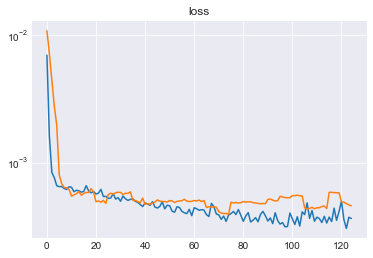

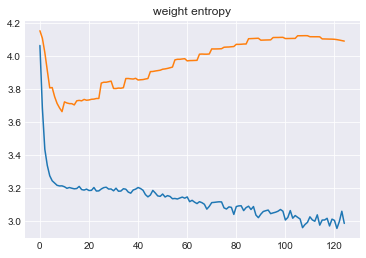

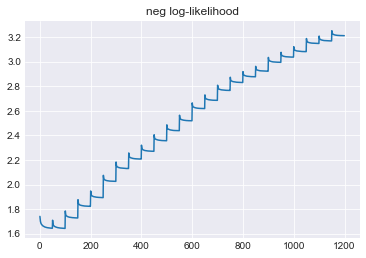

In [16]:
plt.plot(me_history.history['loss'])
plt.plot(hme_history.history['loss'])
plt.plot(hme_final_history.history['loss'])
plt.title('loss')
plt.yscale('log')
plt.show()

plt.plot(me_history.history['weight-entropy'])
plt.plot(hme_history.history['weight-entropy'])
plt.plot(hme_final_history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(hme_history.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

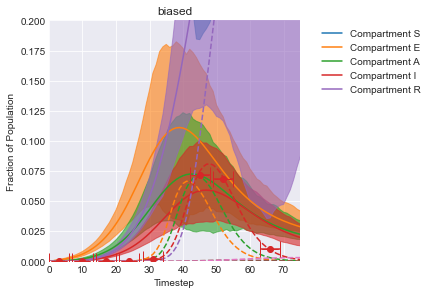

In [26]:
patch_number = 0
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments)
plt.plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(plt, hme_model.lambdas[i], color='C3')
plt.tight_layout()
plt.ylim(0,0.2)
plt.xlim(0,75)
plt.title('biased')
plt.show()


## Direct Regression of Model

In [20]:
T = tmat.value
start = np.zeros((M, C))
start[0,1] = 0.01
infect = maxentep.ContactInfectionLayer(hyper_pram.beta_start, infections_compartments)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, Mobility_martix_norm, T, infect, 201, agreement)

In [21]:
rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(150)
rtraj = rmodel.get_traj()

150/150 [==============================] - 27s 182ms/step - loss: 0.0050 - output_2_loss: 0.0050


## Visualizing results

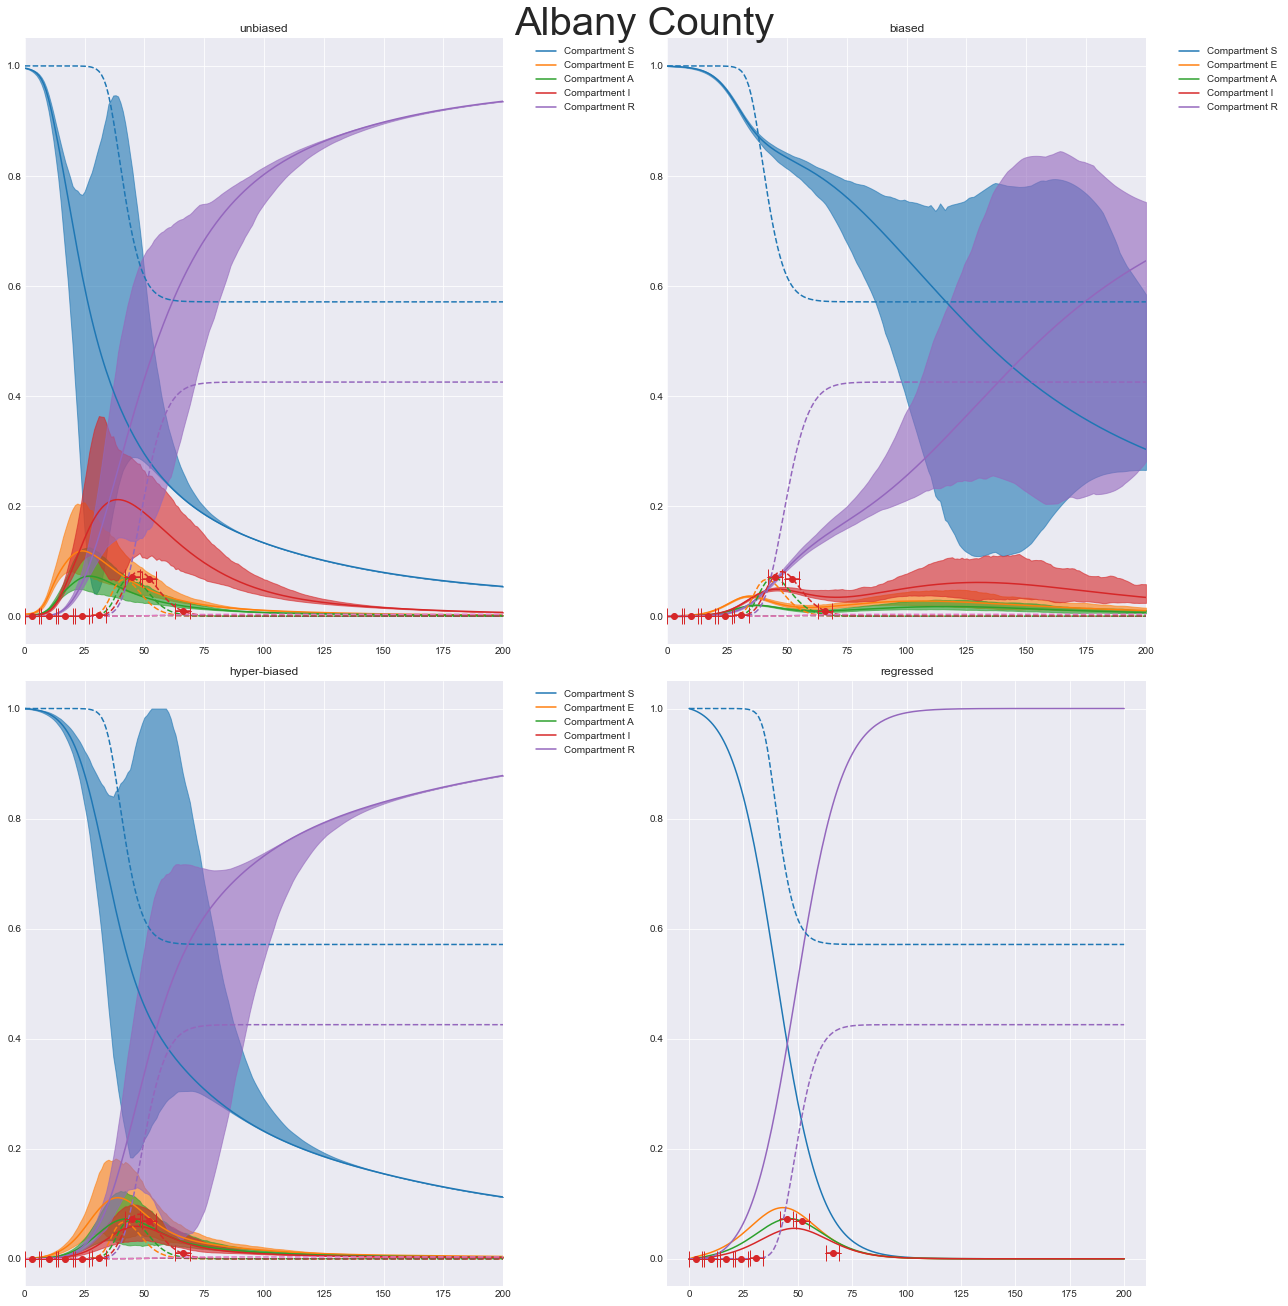

In [22]:
patch_number = 0
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,0], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,1], 1, color='C3')

    
plt.tight_layout()
# plt.savefig('compare_Albany.png', dpi = 300)
plt.show()
plt.close()

In [ ]:
patch_number = 30
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,0], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,1], 1, color='C3')

plt.tight_layout()
# plt.savefig('compare_NY.png', dpi = 300)
plt.show()
plt.close()

In [ ]:
patch_number = 25
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
fig.suptitle('{}'.format(patches[patch_number]), fontsize=40,y=1.005)

axs[0,0].set_title('unbiased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], names=full_compartments, ax=axs[0,0])
axs[0,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,0], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[0,1].set_title('biased')
maxentep.traj_quantile(trajs[:,:,patch_number,:], weights=me_model.traj_weights, names=full_compartments, ax=axs[0,1])
axs[0,1].plot(ref_traj[p,:,patch_number,:], linestyle='--')
# axs[1].plot(ref_traj[p,:,0,0], linestyle='--', color='C0')
for i,pf in enumerate(plot_fxns):
    pf(axs[0,1], me_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,0].set_title('hyper-biased')
maxentep.traj_quantile(hme_model.trajs[:,:,patch_number,:], weights=hme_model.traj_weights, names=full_compartments, ax=axs[1,0])
axs[1,0].plot(ref_traj[p,:,patch_number,:], linestyle='--')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,0], hme_model.lambdas[i], color='C3')
plt.tight_layout()

axs[1,1].set_title('regressed')
axs[1,1].plot(rtraj[0,:,patch_number,:])
axs[1,1].plot(ref_traj[p,:,patch_number,0], linestyle='--',color='C0')
axs[1,1].plot(ref_traj[p,:,patch_number,4], linestyle='--',color='C4')
for i,pf in enumerate(plot_fxns):
    pf(axs[1,1], 1, color='C3')

plt.tight_layout()
plt.savefig('compare_Livingston.png', dpi = 300)
plt.show()
